# Amazon Fine Food Reviews Analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


In [0]:
!pip install pydrive
!pip install gensim
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1cZS7OUXVft4KTZ1AzZPu95hSgWzu3aC8'}) # replace the id with id of file you want to access
downloaded.GetContentFile('final.sqlite')

In [0]:
# loading libraries and data

%matplotlib inline

import sqlite3                          # for sql database
import pandas as pd
import numpy as np
import nltk                             # nltk:- Natural Language Processing Toolkit
import string
import re
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import pickle
def saveindisk(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)
def openfromdisk(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

con = sqlite3.connect("final.sqlite")

# Filtering only positive and negative reviews that is
# not taking into consideration those reviews with score = 3
df = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con)

In [4]:
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut peanut...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [5]:
df.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [6]:
df.shape

(364171, 13)

In [7]:
df['Score'].size

364171

In [8]:
# Taking Sample Datapoints
n_samples = 15000
df_sample = df.sample(n_samples)
df_sample.sort_values('Time', inplace=True) #Sorting with respect to time
df_sample.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
169304,212495,230309,B00004RYGX,A34NBH479RB0E,"""dmab6395""",0,1,Positive,977184000,FUNNY,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA...",b'thought movi funni michael keaton beetlejuic...,b'thought movie funny michael keaton beetlejui...
117349,138016,149787,B00004S1C6,A2XZKD83G4N9Y5,Cindy Elliott,43,45,Positive,1036454400,Great!,"For those wondering, the bottles are each 3/4 ...",b'wonder bottl gel food color vibrant amount g...,b'wondering bottles gel food color vibrant amo...
117267,137934,149702,B00006L2ZT,A25CKRB0P506KH,Jonathan P. Higgins,1,4,Positive,1036627200,Camper van Beethoven is the greatest rock band...,"Well, maybe not &quot;the&quot; greatest, but ...",b'well mayb greatest one best set bring togeth...,b'well maybe greatest one best set brings toge...
117268,137935,149703,B00006L2ZT,A2Y8DAMQ4PHSK9,AWKword,2,6,Positive,1036713600,Never A Dull Moment,"Finally, a collection of the best Camper Van B...",b'final collect best camper van beethoven albu...,b'finally collection best camper van beethoven...
169253,212444,230255,B00004RYGX,A1JZV9MCT6KOX4,"C. Eallonardo ""Kali's Copilot""",0,0,Positive,1037923200,Good Tim Burton Flick,I like Tim Burton movies in general. But this...,b'like tim burton movi general good one your m...,b'like tim burton movies general good one your...


In [0]:
# Function to split train and test set by time

def train_test_split_by_time(X, y, test_ratio = 0.3):
    """
    y parameter needs to be a pandas series
    with timestamp as its index
    """
    
    train_ratio = 1 - test_ratio
    train_end = int(train_ratio * len(y))
    
    sorted_index = np.argsort(y)
    train_index = sorted_index[:train_end]
    test_index = sorted_index[train_end:]
    
    try:
        return X[train_index], X[test_index], y.iloc[train_index], y.iloc[test_index]
    except KeyError:
        # if X is a pandas data structure
        return X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

In [0]:
# From kaggle
from sklearn.model_selection import GridSearchCV

def search_param(clf, param_grid, X, y, test_size=0.3, cv=10, n_jobs=-1,
                 random_search=False, n_iter=10, return_train_score=False):
    """
    Splits the data using time based slicing
    Performs grid search to search for optimal parameter
    using exaustive or random search
    Print accuracy and classification report with
    best parameter on test set
    """
    
    # time based splitting of dataset
    X_train, X_test, y_train, y_test = train_test_split_by_time(X, y, test_size)
    
    if random_search:
        grid_search = RandomizedSearchCV(clf, param_grid, n_iter=n_iter, 
                                         n_jobs=n_jobs, verbose=1, cv=cv, 
                                         return_train_score=return_train_score)
    else:
        grid_search = GridSearchCV(clf, param_grid, n_jobs=n_jobs, 
                                   verbose=1, cv=cv, 
                                   return_train_score=return_train_score)
    
    print('Performing grid search...\n')
    print('Parameters:')
    print(param_grid)
    print()
    
    grid_search.fit(X_train, y_train)
    print('\n')
    
    print("Best CV score: %f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("\nTest score with best_estimator_: %f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("                 Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
    
    return grid_search

# Applying the logistic Regression on the different Vectorizing Techniques


## Bag of Word(BOW)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [12]:
bi_gram = CountVectorizer(min_df=10)
bi_gram_vectors = bi_gram.fit_transform(df_sample['CleanedText'])
bi_gram_vectors.shape

(15000, 3540)

In [0]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split_by_time(bi_gram_vectors,df_sample['Score'])

In [14]:
# Train model with default hyperparameter
clf = LogisticRegression()
clf.fit(X_train, y_train)

print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.9466666666666667


In [15]:
# Column standardization
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([('Scalar', StandardScaler(with_mean=False)),
               ('logreg', LogisticRegression())])
clf.fit(X_train, y_train)
print('Accuracy on test set:', clf.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Accuracy on test set: 0.8955555555555555


By using column standardization, the accuracy decreased by 5%.

In [16]:
# Normalize sample to unitform
clf = Pipeline([
    ('norm', Normalizer()),
    ('logreg', LogisticRegression())
])
clf.fit(X_train, y_train)
print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.9733333333333334


The accuracy is about the same to our original Logistic Regression.

In [17]:
# L1 regularization
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)

print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.9486666666666667


In [18]:
clf = Pipeline([
    ('norm', Normalizer()),
    ('logreg', LogisticRegression(penalty='l1'))
])
clf.fit(X_train, y_train)
print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.962


## Optimal C for L2 regularization
* where C is inverse of lembda

In [0]:
class power_uniform():
    def __init__(self, low=0.0, high=1.0, base=10.0):
        self.low = low
        self.high = high
        self.base = base

    def rvs(self, random_state):
        return self.base ** np.random.uniform(self.low, self.high)


In [20]:
# Using Random search
param_grid = {
    'log__C': power_uniform(-4, 4)
}

clf = Pipeline([
    ('norm', Normalizer()),
    ('log', LogisticRegression(penalty='l2'))
])

best_log = search_param(clf, param_grid, bi_gram_vectors, df_sample['Score'], random_search=True)

Performing grid search...

Parameters:
{'log__C': <__main__.power_uniform object at 0x7f6064001860>}

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.0s finished




Best CV score: 0.874571
Best parameters set:
	log__C: 28.68819227165926

Test score with best_estimator_: 0.947333


                 Classification Report Test Data
             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00         0
   Positive       1.00      0.95      0.97      4500

avg / total       1.00      0.95      0.97      4500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Optimal C for L1 regularization

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit


In [22]:
# Using Random search
param_grid = {
    'log__C': 10.0 ** np.arange(-4, 4)
}

clf = Pipeline([
    ('norm', Normalizer()),
    ('log', LogisticRegression(penalty='l1'))
])

best_log = search_param(clf, param_grid, bi_gram_vectors, df_sample['Score'], n_jobs=-1)

Performing grid search...

Parameters:
{'log__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.8s finished




Best CV score: 0.873429
Best parameters set:
	log__C: 1.0

Test score with best_estimator_: 0.962000


                 Classification Report Test Data
             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00         0
   Positive       1.00      0.96      0.98      4500

avg / total       1.00      0.96      0.98      4500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


* L2 regularization has a slightly better accuracy than L1 regularization.

## Error on changing C parameter in L1 regularization

In [0]:
x = 10.0 ** np.arange(-4, 6)

error = []
cof = []

for i in x:
  clf = Pipeline([('norm', Normalizer()),
                 ('log', LogisticRegression(penalty='l1', C=i))])
  clf.fit(X_train, y_train)
  error.append(1-clf.score(X_test, y_test))
  w = clf.named_steps['log'].coef_
  cof.append(np.count_nonzero(w))

Text(0.5,0,'C (10^x)')

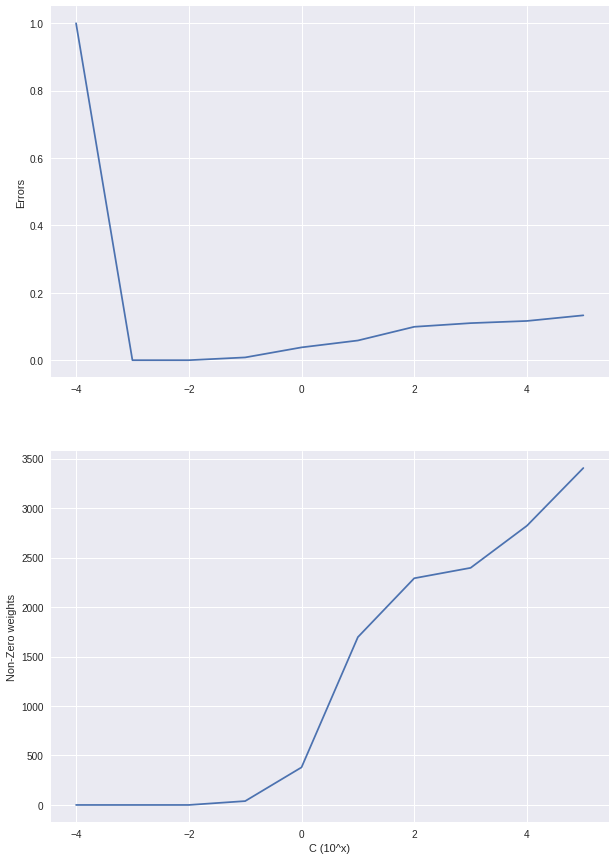

In [24]:
# Drawing two figure in one graph
plt.figure(figsize=(10, 15))
plt.subplot(211)
plt.plot(range(-4, 6), error, label="Errors")
plt.ylabel('Errors')

# 2nd half figure part
plt.subplot(212)
plt.plot(range(-4, 6), cof, label='Non Zero weights')
plt.ylabel('Non-Zero weights')
plt.xlabel('C (10^x)')

## Feature importance

In [0]:
clf = Pipeline([('norm', Normalizer()),
               ('log', LogisticRegression(C=10.0))])
clf.fit(X_train, y_train)

word = {x: i for (i, x) in bi_gram.vocabulary_.items()}
weights = clf.named_steps['log'].coef_.ravel() # ravel convert 2D to 1D
feature_weights = [(word[i], w) for(i, w) in enumerate(weights)]
feature_weights = pd.DataFrame.from_records(feature_weights, columns=['word', 'weights'])
feature_weights['abs_weights'] = feature_weights['weights'].apply(abs)
feature_weights.sort_values('abs_weights', ascending=False, inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


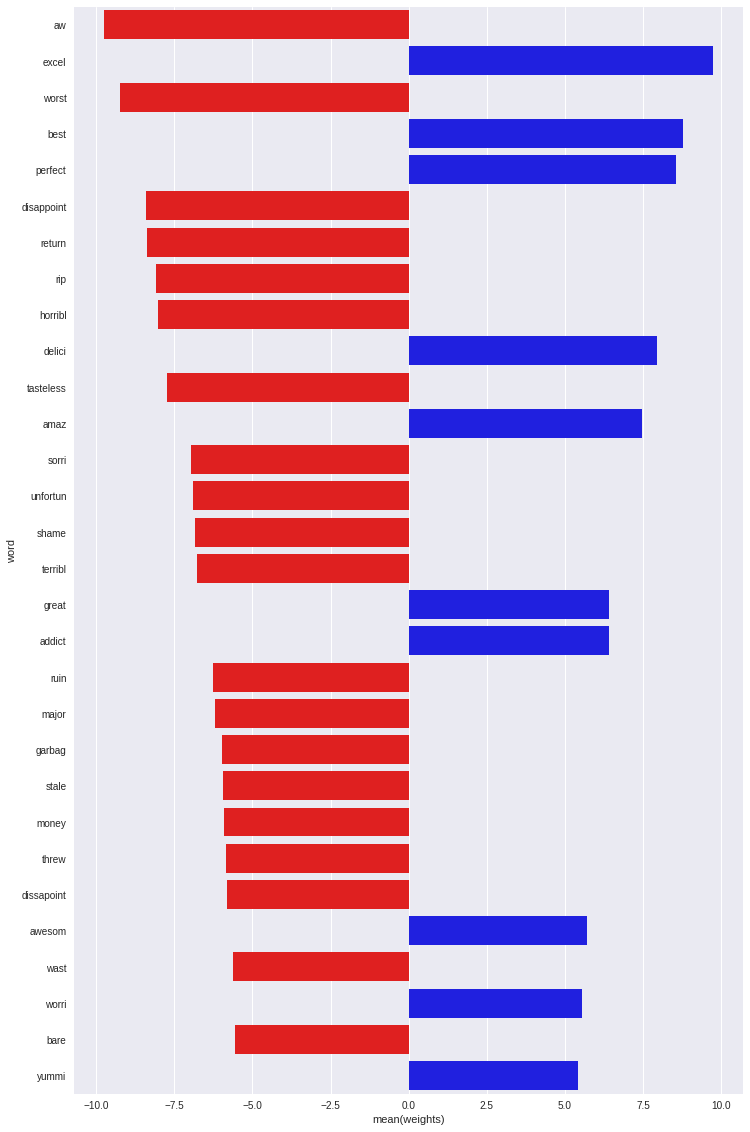

In [26]:
fig, ax =plt.subplots(figsize=(12,20))

pallete = feature_weights['weights'].map(lambda w: 'b' if w > 0 else 'r')
sns.barplot(x='weights', y='word', data=feature_weights.head(30), palette=pallete, ax=ax);

# Tf-Idf Features

In [0]:
tfidf = TfidfVectorizer(min_df=10) 
tfidf_vectors = tfidf.fit_transform(df_sample['CleanedText'].values)

In [0]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split_by_time(tfidf_vectors,df_sample['Score'])

In [29]:
# Train model with default hyperparameter
clf = LogisticRegression()
clf.fit(X_train, y_train)

print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.9793333333333333


In [30]:
# Column standardization
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([('Scalar', StandardScaler(with_mean=False)),
               ('logreg', LogisticRegression())])
clf.fit(X_train, y_train)
print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.8815555555555555


* Column standardization decreases the overall accuracy

In [31]:
# Normalize sample to unitform
clf = Pipeline([
    ('norm', Normalizer()),
    ('logreg', LogisticRegression())
])
clf.fit(X_train, y_train)
print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.9793333333333333


In [32]:
# L1 regularization
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)

print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.9648888888888889


In [33]:
clf = Pipeline([
    ('norm', Normalizer()),
    ('logreg', LogisticRegression(penalty='l1'))
])
clf.fit(X_train, y_train)
print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.9648888888888889


## Optimal C for L2 regularization
* where C is inverse of lembda

In [34]:
# Using Random search
param_grid = {
    'log__C': power_uniform(-4, 4)
}

clf = Pipeline([
    ('norm', Normalizer()),
    ('log', LogisticRegression(penalty='l2'))
])

best_log = search_param(clf, param_grid, tfidf_vectors, df_sample['Score'], random_search=True)

Performing grid search...

Parameters:
{'log__C': <__main__.power_uniform object at 0x7f605784f0f0>}

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.6s finished




Best CV score: 0.881905
Best parameters set:
	log__C: 3.648893738722131

Test score with best_estimator_: 0.962667


                 Classification Report Test Data
             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00         0
   Positive       1.00      0.96      0.98      4500

avg / total       1.00      0.96      0.98      4500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Optimal C for L1 regularization

In [35]:
# Using Random search
param_grid = {
    'log__C': 10.0 ** np.arange(-4, 4)
}

clf = Pipeline([
    ('norm', Normalizer()),
    ('log', LogisticRegression(penalty='l1'))
])

best_log = search_param(clf, param_grid, tfidf_vectors, df_sample['Score'], n_jobs=-1)

Performing grid search...

Parameters:
{'log__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   19.0s finished




Best CV score: 0.877429
Best parameters set:
	log__C: 1.0

Test score with best_estimator_: 0.964889


                 Classification Report Test Data
             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00         0
   Positive       1.00      0.96      0.98      4500

avg / total       1.00      0.96      0.98      4500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Error on changing C parameter in L1 regularization

In [0]:
x = 10.0 ** np.arange(-4, 6)

error = []
cof = []

for i in x:
  clf = Pipeline([('norm', Normalizer()),
                 ('log', LogisticRegression(penalty='l1', C=i))])
  clf.fit(X_train, y_train)
  error.append(1-clf.score(X_test, y_test))
  w = clf.named_steps['log'].coef_
  cof.append(np.count_nonzero(w))

Text(0.5,0,'C (10^x)')

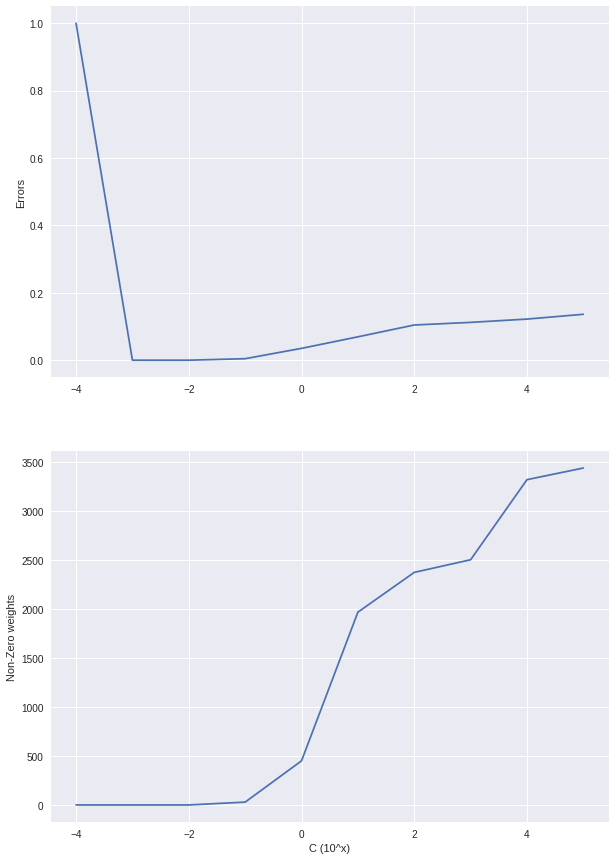

In [37]:
# Drawing two figure in one graph
plt.figure(figsize=(10, 15))
plt.subplot(211)
plt.plot(range(-4, 6), error, label="Errors")
plt.ylabel('Errors')

# 2nd half figure part
plt.subplot(212)
plt.plot(range(-4, 6), cof, label='Non Zero weights')
plt.ylabel('Non-Zero weights')
plt.xlabel('C (10^x)')

## Feature importance

In [0]:
clf = Pipeline([('norm', Normalizer()),
               ('log', LogisticRegression(C=10.0))])
clf.fit(X_train, y_train)

word = {x: i for (i, x) in bi_gram.vocabulary_.items()}
weights = clf.named_steps['log'].coef_.ravel() # ravel convert 2D to 1D
feature_weights = [(word[i], w) for(i, w) in enumerate(weights)]
feature_weights = pd.DataFrame.from_records(feature_weights, columns=['word', 'weights'])
feature_weights['abs_weights'] = feature_weights['weights'].apply(abs)
feature_weights.sort_values('abs_weights', ascending=False, inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


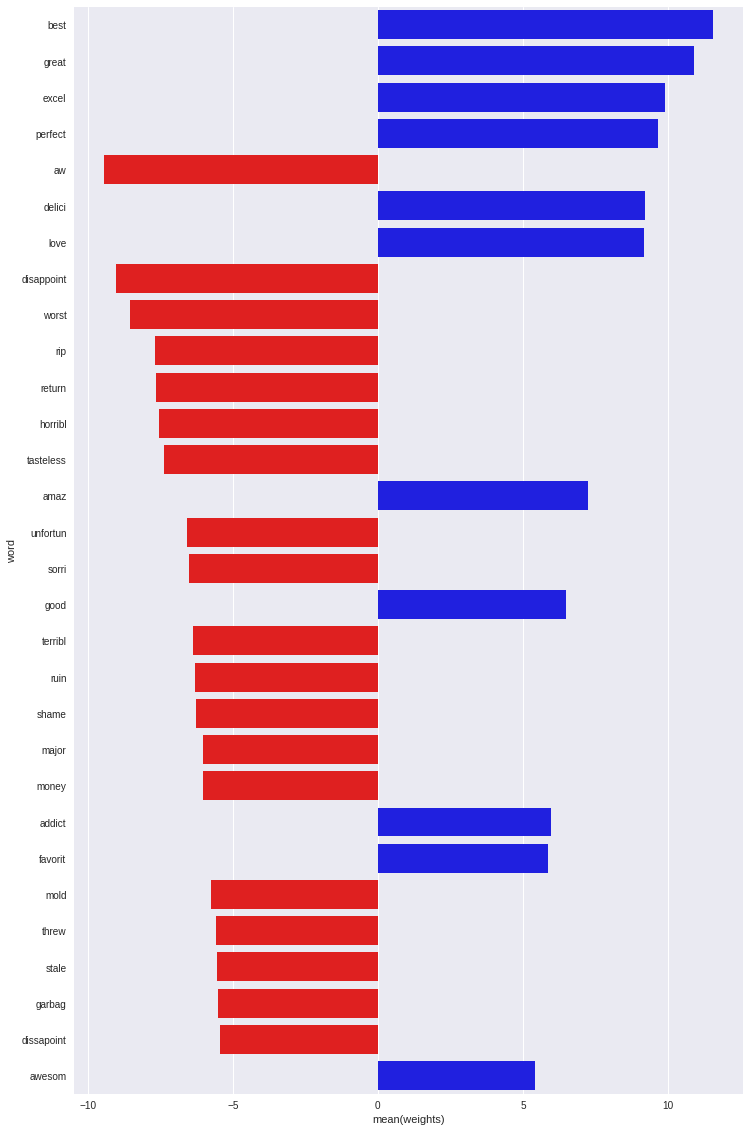

In [39]:
fig, ax =plt.subplots(figsize=(12,20))

pallete = feature_weights['weights'].map(lambda w: 'b' if w > 0 else 'r')
sns.barplot(x='weights', y='word', data=feature_weights.head(30), palette=pallete, ax=ax);

# Avg Word2Vec

In [0]:
list_corpus = df_sample["Text"].tolist()
list_labels = df_sample["Score"].tolist()

In [41]:
from gensim.models import KeyedVectors
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
w2v_model_google = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)


--2018-07-09 23:12:46--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.21.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.21.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  65.0MB/s    in 25s     

2018-07-09 23:13:11 (61.7 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['CleanedText'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [0]:
embeddings = get_word2vec_embeddings(w2v_model_google, df_sample)
X_train, X_test, y_train, y_test = train_test_split(embeddings, list_labels, test_size=0.3, random_state=False)

In [44]:
# Train model with default hyperparameter
clf = LogisticRegression()
clf.fit(X_train, y_train)

print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.8417777777777777


In [45]:
# Column standardization
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([('Scalar', StandardScaler(with_mean=False)),
               ('logreg', LogisticRegression())])
clf.fit(X_train, y_train)
print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.8417777777777777


## Optimal C for L2 regularization
* where C is inverse of lembda

In [46]:
# Using Random search
param_grid = {
    'log__C': power_uniform(-5, 5)
}

clf = Pipeline([
    ('norm', Normalizer()),
    ('log', LogisticRegression(penalty='l2'))
])

tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best HyperParameter:  {'log__C': 517.0786866458167}
Best Accuracy: 84.55%


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.5s finished


## Optimal C for L1 regularization

In [47]:
# Using Random search
param_grid = {
    'log__C': 10.0 ** np.arange(-5, 5)
}

clf = Pipeline([
    ('norm', Normalizer()),
    ('log', LogisticRegression(penalty='l1'))
])

tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best HyperParameter:  {'log__C': 0.01}
Best Accuracy: 84.55%


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.8s finished


## Error on changing C parameter in L1 regularization

Text(0.5,0,'C (10^x)')

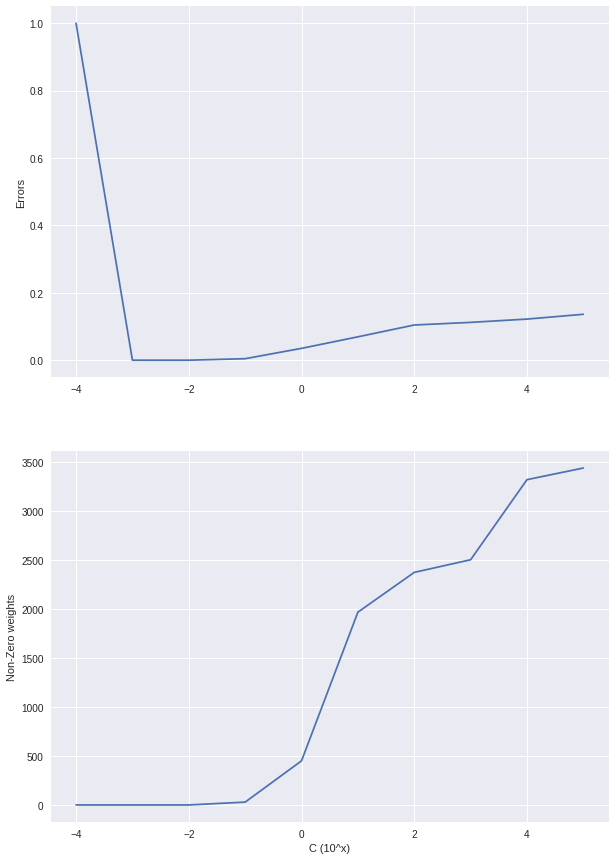

In [48]:
# Drawing two figure in one graph
plt.figure(figsize=(10, 15))
plt.subplot(211)
plt.plot(range(-4, 6), error, label="Errors")
plt.ylabel('Errors')

# 2nd half figure part
plt.subplot(212)
plt.plot(range(-4, 6), cof, label='Non Zero weights')
plt.ylabel('Non-Zero weights')
plt.xlabel('C (10^x)')

## Multicollinearity Check


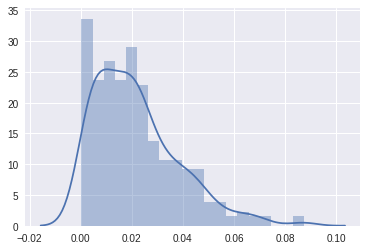

In [49]:
# using pertubation technique
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('log', LogisticRegression())
])

clf.fit(X_train, y_train)

original_weights = clf.named_steps['log'].coef_.ravel()
df = pd.DataFrame(X_train)

# Add small noise and then train
X_train_with_noise = df.applymap(lambda x: x + np.random.normal(0, 0.01))

clf.fit(X_train_with_noise, y_train)

noise_weights = clf.named_steps['log'].coef_.ravel()

# Absolute difference in weights
weight_diffs = np.absolute(original_weights - noise_weights)

# Change in weights
sns.distplot(weight_diffs, bins=20);

# Tf-Idf Word2Vec


In [0]:
from sklearn.base import TransformerMixin, BaseEstimator
from gensim.models import Word2Vec
class tfidfw2v(TransformerMixin, BaseEstimator):

    def __init__(self, size=100, alpha=0.025, window=5, min_count=10, max_vocab_size=None, sample=1e-3, seed=1,
                 workers=3, min_alpha=0.0001, sg=1, hs=0, negative=5, cbow_mean=1, iter=10, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000, tfidf_params ={}):
        
        # Sklearn wrapper for Word2Vec model. See gensim.models.Word2Vec for parameter details.
        self.w2v_model = None
        self.tfidf_model = TfidfVectorizer(**tfidf_params)
        self.size = size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.cbow_mean = int(cbow_mean)
        self.iter = iter
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words

    def fit(self, X, y=None):
        
        # Fit the model according to the given training data.
        # Calls gensim.models.Word2Vec
        
        X_tokenized = X.apply(lambda sent: sent.split())
        
        self.tfidf_model.fit(X)
        
        self.w2v_model = Word2Vec(
            sentences=X_tokenized, size=self.size, alpha=self.alpha,
            window=self.window, min_count=self.min_count, max_vocab_size=self.max_vocab_size,
            sample=self.sample, seed=self.seed, workers=self.workers, min_alpha=self.min_alpha,
            sg=self.sg, hs=self.hs, negative=self.negative, cbow_mean=self.cbow_mean, 
            iter=self.iter, null_word=self.null_word, trim_rule=self.trim_rule,
            sorted_vocab=self.sorted_vocab, batch_words=self.batch_words
        )
        return self

    def transform(self, X):
        return X.apply(self.tfidf_w2v)
    
    def tfidf_w2v(self, sent):
        """
        returns a tf-idf word vector of 
        sentence.
        Word list should be a pd.Series
        with name attribute as index for
        finding the weight of the word from
        tfidf features
        """
        tfidf_feature = self.tfidf_model.transform([sent])
        sent_vec = np.zeros(self.size)
        weight_sum = 0
        for word in sent.split():
            try:
                vec = self.w2v_model.wv[word]
                index = self.tfidf_model.vocabulary_[word]
                weight = tfidf_feature[0, index]
                sent_vec += weight * vec
                weight_sum += weight
            except KeyError:
                pass
        if weight_sum != 0:
            sent_vec /= weight_sum
        return pd.Series(sent_vec)
    
    def most_similar(self, word):
        return self.model.wv.most_similar(word)
    
    def vocabulary(self):
        """
        Returns a sorted dataframe (by frequency)
        with words as index and vector as rows
        """
        
        # build a list of the terms, integer indices and term counts from the word2vec model vocabulary
        ordered_vocab = [(term, voc.index, voc.count)
                         for term, voc in self.w2v_model.wv.vocab.items()]

        # sort by the term counts, so the most common terms appear first
        ordered_vocab = sorted(ordered_vocab, key=lambda k : k[2], reverse=True)

        # unzip the terms, integer indices, and counts into separate lists
        ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

        # create a DataFrame with the word vectors as data and the terms as row labels
        wordvectors = pd.DataFrame(self.w2v_model.wv.vectors_norm[term_indices, :],
                                    index=ordered_terms)

        return wordvectors


In [0]:
from sklearn import preprocessing
tfidf_w2v_model = tfidfw2v()
tfidf_w2v_features = tfidf_w2v_model.fit_transform(df_sample['Text'])

In [0]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(tfidf_w2v_features,df_sample['Score'].values,test_size=0.3,shuffle=False)

In [79]:
# Train model with default hyperparameter
clf = LogisticRegression()
clf.fit(X_train, y_train)

print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.8582222222222222


In [80]:
# Column standardization
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([('Scalar', StandardScaler(with_mean=False)),
               ('logreg', LogisticRegression())])
clf.fit(X_train, y_train)
print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.8595555555555555


In [81]:
# Normalize sample to unitform
clf = Pipeline([
    ('norm', Normalizer()),
    ('logreg', LogisticRegression())
])
clf.fit(X_train, y_train)
print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.8597777777777778


## Optimal C for L2 regularization
* where C is inverse of lembda

In [82]:
# Using Random search
param_grid = {
    'log__C': power_uniform(-4, 4)
}

clf = Pipeline([
    ('norm', Normalizer()),
    ('log', LogisticRegression(penalty='l2'))
])

best_log = search_param(clf, param_grid, tfidf_w2v_features, df_sample['Score'], random_search=True)

Performing grid search...

Parameters:
{'log__C': <__main__.power_uniform object at 0x7f6013dc9780>}

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.9s finished




Best CV score: 0.838000
Best parameters set:
	log__C: 18.139786127818144

Test score with best_estimator_: 0.939333


                 Classification Report Test Data
             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00         0
   Positive       1.00      0.94      0.97      4500

avg / total       1.00      0.94      0.97      4500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Optimal C for L1 regularization


In [83]:
# Using Random search
param_grid = {
    'log__C': 10.0 ** np.arange(-4, 4)
}

clf = Pipeline([
    ('norm', Normalizer()),
    ('log', LogisticRegression(penalty='l1'))
])

best_log = search_param(clf, param_grid, tfidf_w2v_features, df_sample['Score'], n_jobs=-1)

Performing grid search...

Parameters:
{'log__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished




Best CV score: 0.837905
Best parameters set:
	log__C: 100.0

Test score with best_estimator_: 0.938222


                 Classification Report Test Data
             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00         0
   Positive       1.00      0.94      0.97      4500

avg / total       1.00      0.94      0.97      4500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Error on changing C parameter in L1 regularization

In [0]:
x = 10.0 ** np.arange(-4, 6)

error = []
cof = []

for i in x:
  clf = Pipeline([('norm', Normalizer()),
                 ('log', LogisticRegression(penalty='l1', C=i))])
  clf.fit(X_train, y_train)
  error.append(1-clf.score(X_test, y_test))
  w = clf.named_steps['log'].coef_
  cof.append(np.count_nonzero(w))

Text(0.5,0,'C (10^x)')

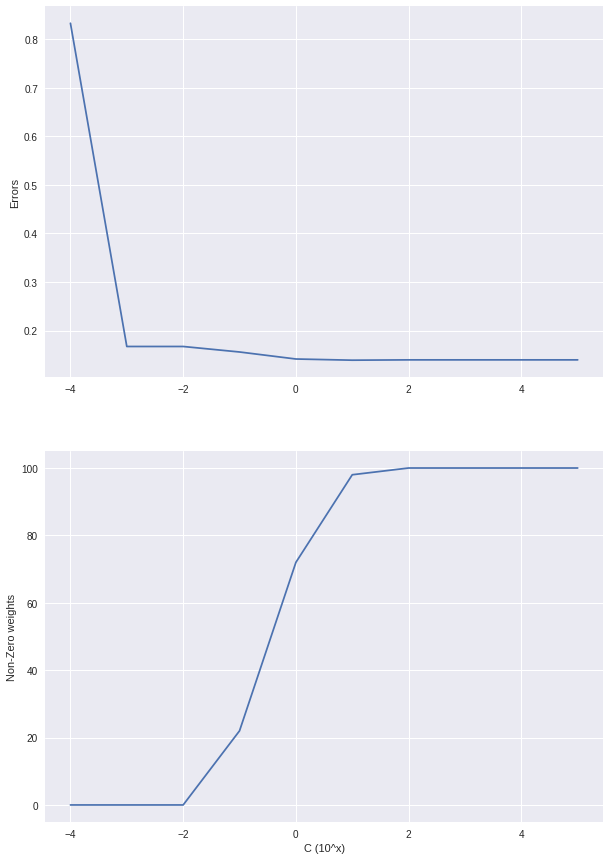

In [85]:
# Drawing two figure in one graph
plt.figure(figsize=(10, 15))
plt.subplot(211)
plt.plot(range(-4, 6), error, label="Errors")
plt.ylabel('Errors')

# 2nd half figure part
plt.subplot(212)
plt.plot(range(-4, 6), cof, label='Non Zero weights')
plt.ylabel('Non-Zero weights')
plt.xlabel('C (10^x)')

## Multicollinearity Check


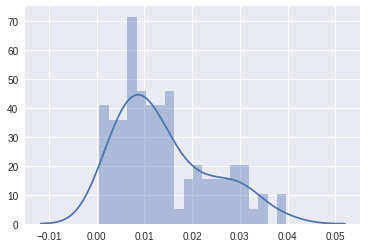

In [86]:
# using pertubation technique
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('log', LogisticRegression())
])

clf.fit(X_train, y_train)

original_weights = clf.named_steps['log'].coef_.ravel()


# Add small noise and then train
X_train_with_noise = X_train.applymap(lambda x: x + np.random.normal(0, 0.01))

clf.fit(X_train_with_noise, y_train)

noise_weights = clf.named_steps['log'].coef_.ravel()

# Absolute difference in weights
weight_diffs = np.absolute(original_weights - noise_weights)

# Change in weights
sns.distplot(weight_diffs, bins=20);

# Comparison of accuracy of Logistic Regression on different features vectors

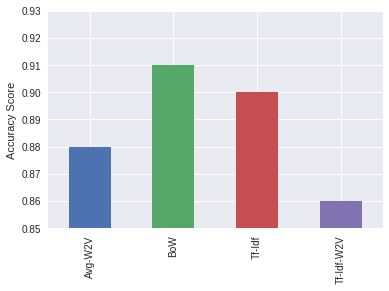

In [87]:
log_model_accuracy = {
    'BoW': 0.91,
    'Tf-Idf':0.90,
    'Avg-W2V': 0.88,
    'Tf-Idf-W2V': 0.86
}

pd.Series(log_model_accuracy).plot(kind='bar')
plt.ylabel('Accuracy Score')
plt.ylim((0.85, 0.93));